<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/03_CNN_exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find an ideal learning rate for a simple convolutional neurla network model on 10-class dataset.

In [ ]:
import zipfile
import random
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [ ]:
# Download required data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip


--2022-07-07 11:23:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.217.204.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   170MB/s    in 2.9s    

2022-07-07 11:23:17 (170 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip","r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} and {len(filenames)} images in '{dirpath}'")

There are 2 and 0 images in '10_food_classes_all_data'
There are 10 and 0 images in '10_food_classes_all_data/test'
There are 0 and 250 images in '10_food_classes_all_data/test/grilled_salmon'
There are 0 and 250 images in '10_food_classes_all_data/test/sushi'
There are 0 and 250 images in '10_food_classes_all_data/test/hamburger'
There are 0 and 250 images in '10_food_classes_all_data/test/pizza'
There are 0 and 250 images in '10_food_classes_all_data/test/fried_rice'
There are 0 and 250 images in '10_food_classes_all_data/test/chicken_wings'
There are 0 and 250 images in '10_food_classes_all_data/test/ice_cream'
There are 0 and 250 images in '10_food_classes_all_data/test/ramen'
There are 0 and 250 images in '10_food_classes_all_data/test/chicken_curry'
There are 0 and 250 images in '10_food_classes_all_data/test/steak'
There are 10 and 0 images in '10_food_classes_all_data/train'
There are 0 and 750 images in '10_food_classes_all_data/train/grilled_salmon'
There are 0 and 750 images

In [ ]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Get class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# Visualize

def view_random_image(target_dir, target_class):
  # Setup the target directory
  target_folder = target_dir+target_class
 
  # get random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # read in the image and plot it using matplotlib

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off")
  print(f"Image shape: {img.shape}")

  return img


['105910.jpg']
Image shape: (384, 512, 3)


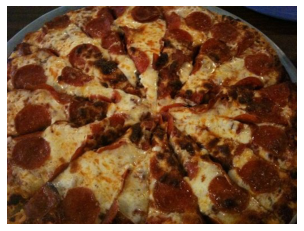

In [ ]:
img = view_random_image(target_dir="10_food_classes_all_data/train/",
                        target_class="pizza")

In [ ]:
img.shape

(384, 512, 3)

## Import Data through ImageDataGenerator

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    rotation_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    horizontal_flip=True
                                    )

test_data_gen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_data = train_data_gen.flow_from_directory(train_dir,
                                                batch_size=32,
                                                target_size=(224,224),
                                                class_mode="categorical")

test_data = test_data_gen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
len(train_data), len(test_data)

(235, 79)

## Create compile, fit, evaluate model and find an ideal learning rate



In [ ]:
# 0. Set random seed
tf.random.set_seed(42)

# 1. Create model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(224,224,3)),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# 2. Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
              

# Create a learning rate callback

@tf.function
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr*tf.math.exp(0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Train the model
history = model.fit(train_data,
          epochs=20,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[lr_scheduler])

Epoch 1/20
235/235 [==============================] - 121s 511ms/step - loss: 2.4958 - accuracy: 0.2392 - val_loss: 1.9969 - val_accuracy: 0.3024 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 119s 507ms/step - loss: 2.0296 - accuracy: 0.2921 - val_loss: 1.9254 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 119s 505ms/step - loss: 2.0049 - accuracy: 0.3081 - val_loss: 1.9057 - val_accuracy: 0.3484 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 119s 509ms/step - loss: 1.9785 - accuracy: 0.3225 - val_loss: 1.9046 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 119s 506ms/step - loss: 1.9579 - accuracy: 0.3273 - val_loss: 1.9346 - val_accuracy: 0.3532 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 119s 505ms/step - loss: 1.9489 - accuracy: 0.3371 - val_loss: 1.8987 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 7/20
235/235 [==========================

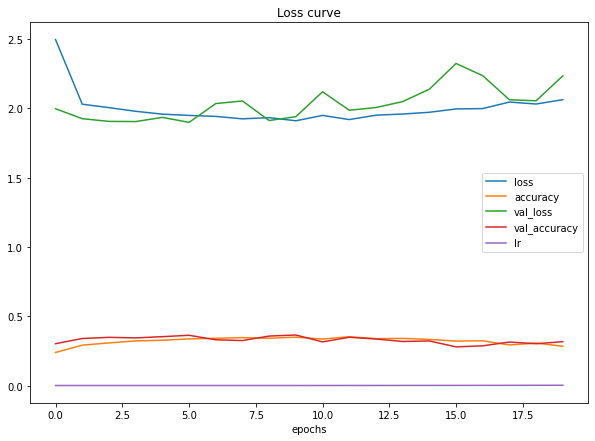

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs", title="Loss curve");

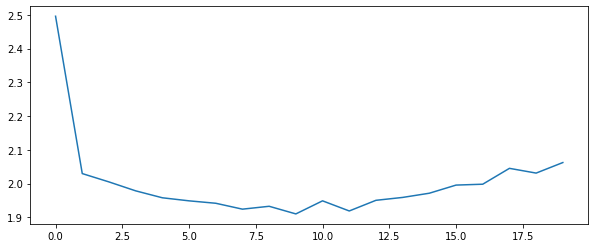

In [ ]:
plt.figure(figsize=(10,4));
plt.plot(history.history["loss"]);


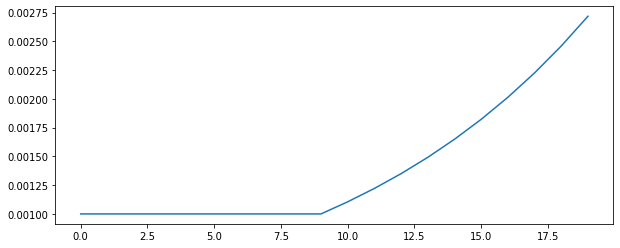

In [ ]:
plt.figure(figsize=(10,4));
plt.plot(history.history["lr"])
